# `1_lists_numpy.ipynb`

This notebok benchmarks different simple stencils (pointwise, 1D, 2D) usin pure Python code (lists), NumPy arrays keeping `for` loops, and NumPy vectorized code.

In [1]:
import math
import numpy as np
from IPython.display import Markdown as md

In [2]:
from common import initialize_field, plot_field, save_result, compare_results, read_results

In [3]:
NX = 128
NY = 128
NZ = 80
N_ITER = 50

## Pointwise stencils

We consider two pointwise stencil models: a simple copy, and applying the `sin` function.

$$
a(i) = b(i)
$$

$$
a(i) = \sin(b(i))
$$

### Nested lists and `for` loops

In [4]:
def list_pointwise(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k][j][i] = in_field[k][j][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

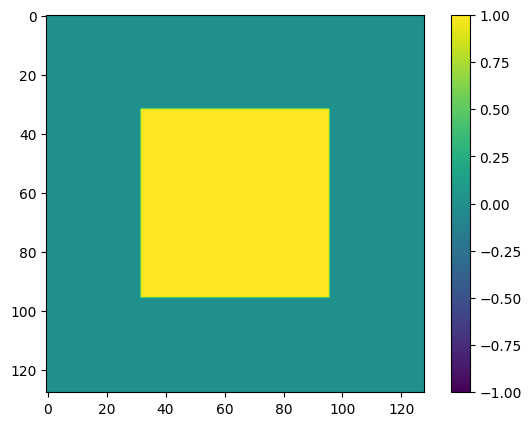

In [5]:
in_field = initialize_field(NX, NY, NZ, mode="square")
# We initialized out_field as zeros to verify that the copy was done correctly
out_field = np.zeros_like(in_field).tolist()
in_field = in_field.tolist()
list_pointwise(in_field, out_field)
# To check if the copy was done
plot_field(out_field)

Before running the first benchmark, let's have a look at how Python lists are stored in memory.

Python lists are totally different from arrays or buffers. Under the hood, the CPython implementation of the list object is a vector of pointers, so each element of a list is by itself a proper Python object (any!) and a pointer to it is what is stored in the list object. Essentially, after removing some comments, the implementation that can be found in [listobject.h](https://github.com/python/cpython/blob/main/Include/cpython/listobject.h) is the following:

```C
typedef struct {
    PyObject_VAR_HEAD
    PyObject **ob_item;
    Py_ssize_t allocated;
} PyListObject;
```

So our 3D fields are in fact a list containing 80 lists (dimension Z), each of these lists containing 128 lists (dimension Y), and finally each of these lists containing 128 floats. Python lists can be enlarge, reduced, and new elements can be inserted or deleted at arbitrary positions. All these make these objects extremely cache unfriendly. When accessing the field element (x,y,z) with `field[z][y][x]` a bunch of pointers have to be followed, and therefore the chances that subsequent values remain in the cache are minimal.

In [6]:
%%timeit -n1 -r3 -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist(); 
list_pointwise(in_field, out_field)

8.27 s ± 7.23 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 8.27 s ± 7.23 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [7]:
result_list_pointwise = _
save_result(result_list_pointwise, "list_pointwise")

Even though Python lists are not ideal to maximize cache hits, it is still expected to see a difference depending on the order of the `for` loops. Let's verify this trying all the possible permutations to itereate over the 3D fields: ZYX (done above), XYZ, XZY, ZXY, YXZ, YZX.

In [8]:
def list_pointwise_XYZ(in_field, out_field):
    for n in range(N_ITER):
        for i in range(NX):
            for j in range(NY):
                for k in range(NZ):
                    out_field[k][j][i] = in_field[k][j][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def list_pointwise_XZY(in_field, out_field):
    for n in range(N_ITER):
        for i in range(NX):
            for k in range(NZ):
                for j in range(NY):
                    out_field[k][j][i] = in_field[k][j][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def list_pointwise_ZXY(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for i in range(NX):
                for j in range(NY):
                    out_field[k][j][i] = in_field[k][j][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def list_pointwise_YXZ(in_field, out_field, plot=False):
    for n in range(N_ITER):
        for j in range(NY):
            for i in range(NX):
                for k in range(NZ):
                    out_field[k][j][i] = in_field[k][j][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field


def list_pointwise_YZX(in_field, out_field):
    for n in range(N_ITER):
        for j in range(NY):
            for k in range(NZ):
                for i in range(NX):
                    out_field[k][j][i] = in_field[k][j][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [9]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist(); 
list_pointwise_XYZ(in_field, out_field)

14.9 s ± 21.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [10]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist(); 
list_pointwise_XZY(in_field, out_field)

11.7 s ± 58.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [11]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist(); 
list_pointwise_ZXY(in_field, out_field)

9.86 s ± 29.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [12]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist(); 
list_pointwise_YXZ(in_field, out_field)

12.2 s ± 59.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [13]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist(); 
list_pointwise_YZX(in_field, out_field)

8.72 s ± 37.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Clearly, by looking at these times, with nested lists we should iterate in the same order as we have nested the lists, i.e., the first level should be looped the slowest, and the innermost level should be looped the fastest. The explanation for this is that to access the element `field[k][j][i+1]` the information (pointers) required to access the innermost list, i.e., `field[k][j]`, is already in the cache, while to get `field[i+1][j][k]` we have to follow a whole new path of pointers, which most likely are not in the cache if the list is large enough.

Furthermore, we would expect that if the fields are initialized with the same order of the nested lists as the loop order, we should obtain similar performance. Let's check this for the cases XYZ and YZX.

In [14]:
def list_pointwise_XYZ_alt(in_field, out_field):
    for n in range(N_ITER):
        for i in range(NX):
            for j in range(NY):
                for k in range(NZ):
                    # Notice the different order to access field elements
                    out_field[i][j][k] = in_field[i][j][k]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def list_pointwise_YZX_alt(in_field, out_field):
    for n in range(N_ITER):
        for j in range(NY):
            for k in range(NZ):
                for i in range(NX):
                    out_field[j][k][i] = in_field[j][k][i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [15]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ, dim_order="XYZ"); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist();
list_pointwise_XYZ_alt(in_field, out_field)

8.34 s ± 12.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [16]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ, dim_order="YZX"); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist();
list_pointwise_YZX_alt(in_field, out_field)

8.27 s ± 13.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Similarly, we could replicate the worst results by using the opposite list structure to the loop order. Let's try this with the two best results from above: ZYX and and YZX.

In [17]:
def list_pointwise_ZYX_alt(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    # Loop ZYX, access XYZ
                    out_field[i][j][k] = in_field[i][j][k]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

def list_pointwise_YZX_alt(in_field, out_field):
    for n in range(N_ITER):
        for j in range(NY):
            for k in range(NZ):
                for i in range(NX):
                    # Loop YZX, access XZY
                    out_field[i][k][j] = in_field[i][k][j]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [18]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ, dim_order="XYZ"); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist();
list_pointwise_ZYX_alt(in_field, out_field)

15.7 s ± 41 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [19]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ, dim_order="XZY"); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist();
list_pointwise_YZX_alt(in_field, out_field)

16.2 s ± 59.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


All these results agree with our previous explanation.

Let's now check the other simple pointwise stencil computation. In this case, instead of just copying all the values, we will compute the sine of each gridpoint.

In [20]:
def list_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    # numpy.sin() is ~7 times slower than math.sin() when applied to single values
                    # Check Appendix at end of notebook for more details
                    out_field[k][j][i] = math.sin(in_field[k][j][i])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [21]:
%%timeit -n1 -r3 -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist(); 
list_sin_pointwise(in_field, out_field)

14.5 s ± 56.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 14.5 s ± 56.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [22]:
result_list_sin_pointwise = _
save_result(result_list_sin_pointwise, "list_sin_pointwise")

Since we are iterating over the field in the optimal permutation, the difference in time with respect to our copy stencil can be attributed to `math.sin()`. We can check this by timing how much it takes to compute a single `math.sin()` operation and multiplying by the number of such calculations.

In [23]:
time_diff = result_list_sin_pointwise.average - result_list_pointwise.average
print(time_diff)

6.267734016912678


In [24]:
%%timeit -o import random; x = random.random()
y = math.sin(x)

83.5 ns ± 0.264 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


<TimeitResult : 83.5 ns ± 0.264 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)>

In [25]:
time_sin = _

In [26]:
loosingtime_sin.average * NZ * NY * NX * N_ITER

5.471442254638672

### NumPy arrays and `for` loops

The following code will show the worst we can do when trying to work with NumPy arrays. Surprisingly, as we will see in [the Numba notebook](./2_numba.ipynb), this is the preferred way to write code that will be later compiled by Numba.

In [27]:
def array_pointwise(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

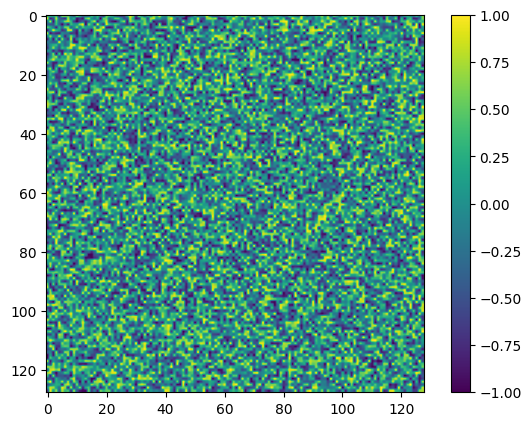

In [28]:
in_field = initialize_field(NX, NY, NZ)
out_field = np.zeros_like(in_field)
out_field = array_pointwise(in_field, out_field)
# To check that the copy was done
plot_field(out_field)

In [29]:
%%timeit -n1 -r3 -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = array_pointwise(in_field, out_field)

15.1 s ± 25.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 15.1 s ± 25.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [30]:
result_array_pointwise = _
save_result(result_array_pointwise, "array_pointwise")

However, it is still interesting to try all the possible permutations of the `for` loops. Hopefully, this will give us some hints about how NumPy arrays are stored in memory.

In [31]:
def array_pointwise_ZYX(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

def array_pointwise_XYZ(in_field, out_field):
    for n in range(N_ITER):
        for i in range(NX):
            for j in range(NY):
                for k in range(NZ):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

def array_pointwise_XZY(in_field, out_field):
    for n in range(N_ITER):
        for i in range(NX):
            for k in range(NZ):
                for j in range(NY):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field
            
def array_pointwise_ZXY(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for i in range(NX):
                for j in range(NY):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field
            
def array_pointwise_YXZ(in_field, out_field):
    for n in range(N_ITER):
        for j in range(NY):
            for i in range(NX):
                for k in range(NZ):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

def array_pointwise_YZX(in_field, out_field):
    for n in range(N_ITER):
        for j in range(NY):
            for k in range(NZ):
                for i in range(NX):
                    out_field[k, j, i] = in_field[k, j, i]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

In [32]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = array_pointwise_ZYX(in_field, out_field)

15.2 s ± 72.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [33]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = array_pointwise_XYZ(in_field, out_field)

15.5 s ± 97.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [34]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = array_pointwise_XZY(in_field, out_field)

15.3 s ± 82.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [35]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = array_pointwise_ZXY(in_field, out_field)

15.2 s ± 81.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [36]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = array_pointwise_YXZ(in_field, out_field)

15.5 s ± 80.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [37]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = array_pointwise_YZX(in_field, out_field)

15.1 s ± 2.83 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


We observe some differences between some of the loop permutations. However, the important result is that **they are all much slower than when working with lists**. A possible explanation for this is that NumPy arrays are, by design, not cache frienly when accessed element by element. To actually understand this result we need to dig a bit deeper, and understand how NumPy arrays are stored in memory.

NumPy arrays are objects with two very different parts: a data buffer (a contiguous and fixed block of memory containing fixed-sized data items) and a metadata block about the data buffer. The data buffer is very close to what C/Fortran developers would call an array. The metadata contains all the required information so that NumPy can correctly interpret the data buffer (e.g. strides, dim order, byte order, dtype, ...). NumPy deals with changes in arrays very efficiently avoiding unncessary copies. For example, reshaping an array only do changes to the metadata block but leaves the data buffer untouched. This is great, but it is something one has to keep in mind when trying to optimize NumPy code or trying to explain some results.

With this brief explanation we are ready to explain why previous tests were so terribly slow. The main reason is that every time we call `out_field[k, j, i] = in_field[k, j, i]` the metadata of both `in_field` and `out_field` arrays have to be read just to figure out how to access the desired element fields. Then, the relevant part of the data buffer is copied to cache. However, when we try to copy the next point, the metadata has to be loaded again to cache, evicting the data buffer from cache, and so on. This code does not make good use of our CPU cache.

Now let's run the benchmark for the `sin()` stencil and save the results.

In [38]:
def array_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = math.sin(in_field[k, j, i])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

In [39]:
%%timeit -n1 -r3 -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = array_sin_pointwise(in_field, out_field)

24.2 s ± 9.74 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 24.2 s ± 9.74 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [40]:
result_array_sin_pointwise = _
save_result(result_array_sin_pointwise, "array_sin_pointwise")

Since we are using the `math.sin()` function and not the vectorized `numpy.sin()`, the difference in time should be roughly the same we observed when working with lists.

In [41]:
time_diff = result_array_sin_pointwise.average - result_array_pointwise.average
print(time_diff)

9.06475966454794


This is even slower, and probably the reason is that the float number has to first be copied from the data buffer to a Python float object.

### NumPy arrays with vectorized code

Now we test the performance of the same two pointwise stencils using NumPy vectorized code that does not use `for` loops to iterate over the three spatial dimensions.

This is how NumPy should be used. Leaving aside the overhead of Python `for` loops, this code is cache friendly because the metadata of both arrays is read only once, and subsequently only the data buffers are read to make the actual copy. Because of this, large chuncks of the array can be copied by reading directly from the cache instead of memory.

In [42]:
def numpy_pointwise(in_field, out_field):
    for n in range(N_ITER):
        out_field[:, :, :] = in_field[:, :, :]
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

In [43]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

35.7 µs ± 492 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


<TimeitResult : 35.7 µs ± 492 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)>

In [44]:
result_numpy_pointwise = _
save_result(result_numpy_pointwise, "numpy_pointwise")

This is extremely fast! Clearly, NumPy is loading all the data buffer into the cache and not reading from memory to make the whole copy. In [this Appendix](#appendix-L3) we explore how to use this timing to estimate the size of the L3 cache.

In [45]:
def numpy_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        out_field = np.sin(in_field)
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

In [46]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numpy_sin_pointwise(in_field, out_field)

872 ms ± 3.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 872 ms ± 3.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [47]:
result_numpy_sin_pointwise = _
save_result(result_numpy_sin_pointwise, "numpy_sin_pointwise")

In [48]:
numpy_vs_lists_sin = compare_results(result_numpy_sin_pointwise.average, result_list_sin_pointwise.average, "faster")

md(f"""
The conclusion of these first tests with pointwise stencils is that Python loops are **terribly slow**.
Python lists are not cache friendly but, nevertheless, they are surprisingly fast if one takes into
account how flexible they are.

As a matter of fact, NumPy arrays can make things worse if they are used incorrectly, e.g., by iterating over the arrays,
because they are even less cache friendly than lists. However, when combined with vectorized code, performance
can be increased a lot. For example, the pointwise stencil applying `sin()` using NumPy vectorized code is
**{numpy_vs_lists_sin}x faster** than using Python lists. 
""")


The conclusion of these first tests with pointwise stencils is that Python loops are **terribly slow**.
Python lists are not cache friendly but, nevertheless, they are surprisingly fast if one takes into
account how flexible they are.

As a matter of fact, NumPy arrays can make things worse if they are used incorrectly, e.g., by iterating over the arrays,
because they are even less cache friendly than lists. However, when combined with vectorized code, performance
can be increased a lot. For example, the pointwise stencil applying `sin()` using NumPy vectorized code is
**~17x faster** than using Python lists. 


## 1D stencils

1D stencils updating with values from the same row or same colum only and with periodic boundary conditions.

$$
a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]
$$

$$
a(i,j) = \frac{1}{2} \Big[b(i,j+1) - b(i,j)\Big]
$$

The factor 1/2 is to avoid getting huge numbers when `N_ITER` is large with the simple initialization patterns we defined before.

The 1D stencils are the perfect opportunity to validate our explanation about why Python lists are slow. We should be able to observe and measure the effects of writing more or less cache friendly code by changing the order of the `for` loops and the order of how the lists are nested.

###  Same column: $a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]$

This stencil updates each gridpoint with the current value and the value in the next column. For this reason, the optimal code will be the one that iterates the lists in the ZYX order, with the nested lists also stored in that order.

But let's start with our default list order, i.e. ZYX, and the ZXY order for the `for` loops.

In [49]:
def list_1D_same_col_ZXY(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for i in range(NX - 1):
                for j in range(NY):
                    out_field[k][j][i] = 0.5 * (in_field[k][j][i+1] - in_field[k][j][i])
                    # Periodic boundary condition
                    out_field[k][j][NX-1] = 0.5 * (in_field[k][j][0] - in_field[k][j][NX-1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

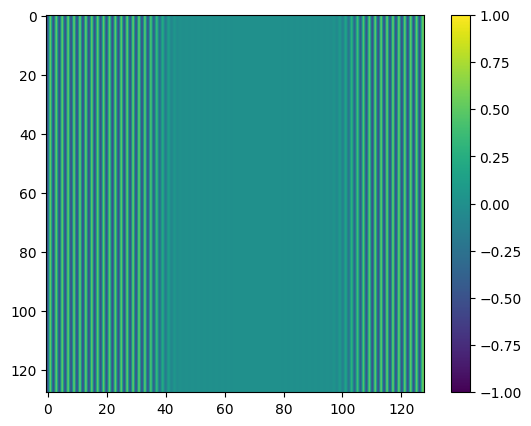

In [50]:
# We can use the pattern of vertical bars to check the correctness
# but later in the benchmarks we will always use random fields
in_field = initialize_field(NX, NY, NZ, mode="vertical-bars")
out_field = np.zeros_like(in_field).tolist()
in_field = in_field.tolist()
list_1D_same_col_ZXY(in_field, out_field)
plot_field(out_field)

In [51]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist(); 
list_1D_same_col_ZXY(in_field, out_field)

36.5 s ± 24.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [52]:
def list_1D_same_col_ZYX(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX - 1):
                    out_field[k][j][i] = 0.5 * (in_field[k][j][i+1] - in_field[k][j][i])
                out_field[k][j][NX-1] = 0.5 * (in_field[k][j][0] - in_field[k][j][NX-1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [53]:
%%timeit -n1 -r3 -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist(); 
list_1D_same_col_ZYX(in_field, out_field)

15 s ± 9.66 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 15 s ± 9.66 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [54]:
result_list_1D_same_col_ZYX = _
save_result(result_list_1D_same_col_ZYX, "list_1D_same_col_ZYX")

By looking at the identation of the code, we can also realize that by choosing the optimal way to iterate and nest the lists, we can save a few operations by only updating the boundary conditions once every `NX` times. This, together with the higher cache hit ratio, explains the better performance of this scenario. We can quickly check the impact of the extra operations by identing the single line so that it belongs to the innermost loop.

In [55]:
def list_1D_same_col_ZYX_alt(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX - 1):
                    out_field[k][j][i] = 0.5 * (in_field[k][j][i+1] - in_field[k][j][i])
                    out_field[k][j][NX-1] = 0.5 * (in_field[k][j][0] - in_field[k][j][NX-1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [56]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist(); 
list_1D_same_col_ZYX_alt(in_field, out_field)

32.7 s ± 15 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Finally, let's verify our hypothesis that the order of the two outer loops should not afffect performance as long as the nested lists follow the same order.

In [57]:
def list_1D_same_col_YZX(in_field, out_field):
    for n in range(N_ITER):
        for j in range(NY):
            for k in range(NZ):
                for i in range(NX - 1):
                    out_field[k][j][i] = 0.5 * (in_field[k][j][i+1] - in_field[k][j][i])
                out_field[k][j][NX-1] = 0.5 * (in_field[k][j][0] - in_field[k][j][NX-1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [58]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist(); 
list_1D_same_col_YZX(in_field, out_field)

15.3 s ± 16.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Next, we will not benchmark NumPy arrays with `for` loops because we already know from the tests using pointwise stencils that this will be much worse than lists. So we will jump directly to explore the 1D stencil using vectorized NumPy code.

In [59]:
def numpy_1D_same_col(in_field, out_field):
    for n in range(N_ITER):
        out_field[:, :, :-1] = 0.5 * (in_field[:, :, 1:] - in_field[:, :, :-1])
        # Periodic boundary condition
        out_field[:, :, -1] = 0.5 * (in_field[:, :, 0] - in_field[:, :, -1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

With vectorized code we cannot test different loop orders. The iteration over arrays is done internally by NumPy. However, we can explore the effects of storing the data in the data buffer differently. A first test we can do is to initialize the arrays using the Fortran-style rather than the C-style (default), and check whether this affects performance or not.

In [60]:
%%timeit -n10 -r7 in_field = initialize_field(NX, NY, NZ, array_order="C"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_same_col(in_field, out_field)

170 ms ± 854 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [61]:
%%timeit -n10 -r7 -o in_field = initialize_field(NX, NY, NZ, array_order="F"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_same_col(in_field, out_field)

109 ms ± 623 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 109 ms ± 623 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [62]:
result_numpy_1D_same_col = _
save_result(result_numpy_1D_same_col, "numpy_1D_same_col")

By default, the data buffers of NumPy arrays are stored row-wise (C), but as shown above this can be changed using the NumPy kwarg `order` (in this case, `array_order` simply passes its value to `order` as one can check in [`common.py`](./common.py)). From NumPy documentation:

> Data in new ndarrays is in the row-major (C) order, unless otherwise specified, but, for example, basic array slicing often produces views in a different scheme.
> (...)
> Several algorithms in NumPy work on arbitrarily strided arrays. However, some algorithms require single-segment arrays. When an irregularly strided array is passed in to such algorithms, a copy is automatically made.

The main takeaway should be that when using vectorized NumPy code, some situations may lead to worse performance than what one would expect. This may be due to extra copies being done by NumPy internally so that the data buffers of the arrays are stored in a certain way.

To gather a bit more data, let's measure the times for the two permutations ZYX and YZX of the `dim_order`, each of which in C-style and Fortran-style.

In [63]:
%%timeit -n10 -r7 in_field = initialize_field(NX, NY, NZ, dim_order="ZYX", array_order="C"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_same_col(in_field, out_field)

171 ms ± 741 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
%%timeit -n10 -r7 in_field = initialize_field(NX, NY, NZ, dim_order="ZYX", array_order="F"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_same_col(in_field, out_field)

109 ms ± 609 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
%%timeit -n10 -r7 in_field = initialize_field(NX, NY, NZ, dim_order="YZX", array_order="C"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_same_col(in_field, out_field)

170 ms ± 918 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [66]:
%%timeit -n10 -r7 in_field = initialize_field(NX, NY, NZ, dim_order="YZX", array_order="F"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_same_col(in_field, out_field)

109 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


There seems to be little difference between the different `dim_order` (~ 1 ms), and what matters most in this case is if the array is stored in C-style (row-major) or Fortran-style (col-major).

To explain these results we need to understand how arbitrary N-dimensional arrays are stored in a one-dimensional segment of computer memory. In particular, let's suppose that `array` is a N-dimensional array with dimensions $d=(d_0,d_1,\dots,d_{N-1})$. The offset of element $(n_0,n_1,\dots,n_{N-1})$, i.e., the number of bytes from the beginning of the data buffer to this particular element, is given by the formula

$$
n_\text{offset} = \sum_{k=0}^{N-1} s_k n_k\,,
$$

where $s_k$ are the so-called strides of the array, i.e., the number of bytes required to advance one position in the $k$ dimension. These strides are precisely the numbers that change when we store the data in C-style or Fortran-style. In particular, we have that

$$
s_k^{\text{Fortran-style}} = \text{itemsize}\times\prod_{j=0}^{k-1}d_j\,,\quad s_k^{\text{C-style}} = \text{itemsize}\times\prod_{j=k+1}^{N-1}d_j\,.
$$

The main takeaway from this is that NumPy arrays in C-style have contiguous elements from the first dimension closer to each other, and in Fortran-style is the opposite, i.e., elements from the last dimension are closer to each other.

For example, for our 3D fields with $d=(\text{NZ},\text{NY},\text{NX})$, we get that for Fortran-style arrays $s_Z=8$, $s_Y=8\times\text{NZ}=640$ and $s_X=8\times\text{NZ}\times\text{NY}=81920$, and for C-style arrays $s_Z=8\times\text{NY}\times\text{NX}=131072$, $s_Y=8\times\text{NY}=1024$ and $s_X=8$. Let's verify this.

In [67]:
field_C = initialize_field(NX, NY, NZ, dim_order="ZYX", array_order="C")
field_F = initialize_field(NX, NY, NZ, dim_order="ZYX", array_order="F")
print(f"C-style: {field_C.strides}")
print(f"Fortran-style: {field_F.strides}")

C-style: (131072, 1024, 8)
Fortran-style: (8, 640, 81920)


Based on this we can explain the differences observed in previous benchmarks: `numpy_1D_same_col()` is always slower when the arrays are C-style because the strides are larger (due to `NZ` being smaller than `NX` and `NY`), leading to a lower cache hit ratio. This difference should go away if we make `NZ` = `NX`. Let's check.

In [68]:
NZ = 128

In [69]:
%%timeit -n10 -r7 in_field = initialize_field(NX, NY, NZ, array_order="C"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_same_col(in_field, out_field)

325 ms ± 5.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [70]:
%%timeit -n10 -r7 in_field = initialize_field(NX, NY, NZ, array_order="F"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_same_col(in_field, out_field)

272 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Results are similar but they are still not equal. This might be due to how NumPy internally iterate over the different dimensions. The next experiment we can do is change the index where we apply the stencil. Since we are working with 3D fields, we have three options.

In [71]:
def numpy_1D_index_1(in_field, out_field):
    for n in range(N_ITER):
        out_field[:-1, :, :] = 0.5 * (in_field[1:, :, :] - in_field[:-1, :, :])
        # Periodic boundary condition
        out_field[-1, :, :] = 0.5 * (in_field[0, :, :] - in_field[-1, :, :])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

def numpy_1D_index_2(in_field, out_field):
    for n in range(N_ITER):
        out_field[:, :-1, :] = 0.5 * (in_field[:, 1:, :] - in_field[:, :-1, :])
        # Periodic boundary condition
        out_field[:, -1, :] = 0.5 * (in_field[:, 0, :] - in_field[:, -1, :])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

def numpy_1D_index_3(in_field, out_field):
    for n in range(N_ITER):
        out_field[:, :, :-1] = 0.5 * (in_field[:, :, 1:] - in_field[:, :, :-1])
        # Periodic boundary condition
        out_field[:, :, -1] = 0.5 * (in_field[:, :, 0] - in_field[:, :, -1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

Since we still have `NX` = `NY` = `NZ` = 128, this will test the impact of the dimension we update with the stencil.

In [72]:
%%timeit -n10 -r7 in_field = initialize_field(NX, NY, NZ, array_order="C"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_index_1(in_field, out_field)

265 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
%%timeit -n10 -r7 in_field = initialize_field(NX, NY, NZ, array_order="C"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_index_2(in_field, out_field)

223 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
%%timeit -n10 -r7 in_field = initialize_field(NX, NY, NZ, array_order="C"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_index_3(in_field, out_field)

323 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [75]:
%%timeit -n10 -r7 in_field = initialize_field(NX, NY, NZ, array_order="F"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_index_1(in_field, out_field)

323 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [76]:
%%timeit -n10 -r7 in_field = initialize_field(NX, NY, NZ, array_order="F"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_index_2(in_field, out_field)

227 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [77]:
%%timeit -n10 -r7 in_field = initialize_field(NX, NY, NZ, array_order="F"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_index_3(in_field, out_field)

269 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


It seems that due to how NumPy iterates over the arrays, it is best to put the dimension that is being update in the middle index of the array. This seems to maximize the cache hit ratio.

In [78]:
NZ = 80

### Same row: $a(i,j) = \frac{1}{2} \Big[b(i,j+1) - b(i,j)\Big]$

Now, in this other stencil, we want the innermost loop to iterate over the rows. This means that the optimal loop permutations are ZXY and XZY.

In [79]:
def list_1D_same_row_ZXY(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for i in range(NX):
                for j in range(NY-1):
                    out_field[k][j][i] = 0.5 * (in_field[k][j+1][i] - in_field[k][j][i])
                out_field[k][NY-1][i] = 0.5 * (in_field[k][0][i] - in_field[k][NY-1][i])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

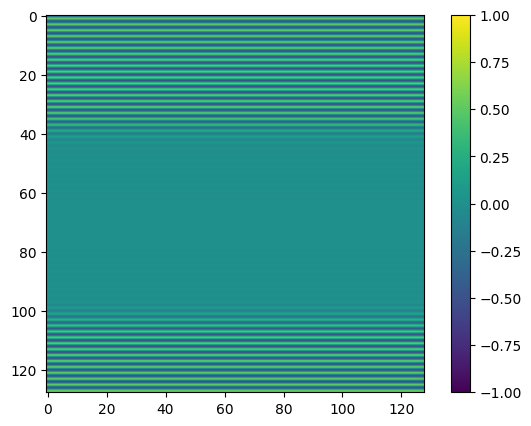

In [80]:
in_field = initialize_field(NX, NY, NZ, mode="horizontal-bars")
out_field = np.zeros_like(in_field).tolist()
in_field = in_field.tolist()
list_1D_same_row_ZXY(in_field, out_field)
plot_field(out_field)

In [81]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist()
list_1D_same_row_ZXY(in_field, out_field)

16.6 s ± 14.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


This result is quite good because the order of the loops is the right one (and we already benefit form less calls to the boundary contidion update), but we can still improve it by nesting the lists in the same way as the loops.

In [82]:
def list_1D_same_row_ZXY_alt(in_field, out_field):
    for n in range(N_ITER):
        for k in range(NZ):
            for i in range(NX):
                for j in range(NY-1):
                    out_field[k][i][j] = 0.5 * (in_field[k][i][j+1] - in_field[k][i][j])
                out_field[k][i][NY-1] = 0.5 * (in_field[k][i][0] - in_field[k][i][NY-1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [83]:
%%timeit -n1 -r3 -o in_field = initialize_field(NX, NY, NZ, dim_order="ZXY"); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist()
list_1D_same_row_ZXY_alt(in_field, out_field)

15 s ± 8.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 15 s ± 8.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [84]:
result_list_1D_same_row_ZXY = _
save_result(result_list_1D_same_row_ZXY, "list_1D_same_row_ZXY")

Let's check that we get similar time with the other optimal setting.

In [85]:
def list_1D_same_row_XZY(in_field, out_field):
    for n in range(N_ITER):
        for i in range(NX):
            for k in range(NZ):
                for j in range(NY-1):
                    out_field[i][k][j] = 0.5 * (in_field[i][k][j+1] - in_field[i][k][j])
                out_field[i][k][NY-1] = 0.5 * (in_field[i][k][0] - in_field[i][k][NY-1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field

In [86]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ, dim_order="XZY"); out_field = np.zeros_like(in_field).tolist(); in_field = in_field.tolist()
list_1D_same_row_XZY(in_field, out_field)

15 s ± 12.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Finally, let's check the vectorized NumPy code. We are now in a position to try to guess what will happen. Using our default `dim_order="ZYX"`, this stencil uses values from the second dimension. This means, based on previous results, that we should see similar performance no matter if we use C-style or Fortran-style arrays.

In [87]:
def numpy_1D_same_row(in_field, out_field):
    for n in range(N_ITER):
        out_field[:, :-1, :] = 0.5 * (in_field[:, 1:, :] - in_field[:, :-1, :])
        # Periodic boundary condition
        out_field[:, -1, :] = 0.5 * (in_field[:, 0, :] - in_field[:, -1, :])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

In [88]:
%%timeit in_field = initialize_field(NX, NY, NZ, array_order="C"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_same_row(in_field, out_field)

102 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [89]:
%%timeit -o in_field = initialize_field(NX, NY, NZ, array_order="F"); out_field = np.zeros_like(in_field)
out_field = numpy_1D_same_row(in_field, out_field)

101 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 101 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [90]:
result_numpy_1D_same_row = _
save_result(result_numpy_1D_same_row, "numpy_1D_same_row")

In [91]:
time_list_1D_same_row_ZXY = read_results("list_1D_same_row_ZXY")
numpy_vs_lists = compare_results(result_numpy_1D_same_row.average, time_list_1D_same_row_ZXY, "faster")

md(f"""
The 1D stencils using vectorized code NumPy are **{numpy_vs_lists} times faster
than pure Python code with lists**.
""")


The 1D stencils using vectorized code NumPy are **~149 times faster
than pure Python code with lists**.


## 2D stencil

The last stencil we will check is the 4th-order non-monotonic diffusion we used during the course, which is defined in terms of the Laplace operator as

$$
a(i, j) = \Delta(\Delta(b(i, j)))
$$

More details about the discretization and the exact stencil can be found in [the project report](./report.pdf).

Since it is already clear from the experiments with pointwise and 1D stencils, that python `for` loops are very slow. Here we will only run the NumPy implementation from `stencil2d.py` given in the course. This will set the base time to improve using the different high-level programming techniques available in Python (which will be tested in different notebooks).

In [92]:
from stencil2d import apply_diffusion

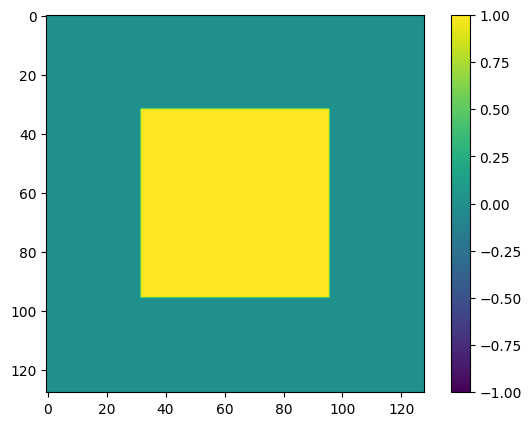

In [93]:
in_field = initialize_field(NX, NY, NZ, mode="square")
plot_field(in_field)

In [94]:
out_field = apply_diffusion(in_field, num_halo=2, num_iter=N_ITER)

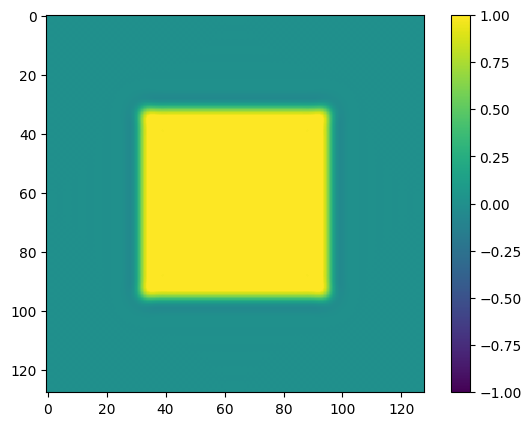

In [95]:
plot_field(out_field)

In [96]:
%%timeit -o in_field = initialize_field(NX, NY, NZ)
out_field = apply_diffusion(in_field, num_halo=2, num_iter=N_ITER)

1.11 s ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.11 s ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [97]:
result_numpy_2D = _
save_result(result_numpy_2D, "numpy_2D")

---
## Appendices

### np.sin() vs math.sin()

There is no doubt that `np.sin()` is faster than `math.sin()` when applied to large NumPy arrays. But this function has an overhead cost when applied to single elements. Here we show that `math.sin()` is more efficient than `np.sin()` when applied to 4 or less elements. However, the overhead of a Python loop is even worse than the overhead of `np.sin()`.

In [98]:
rng = np.random.default_rng()
x = rng.random(100)

In [99]:
%timeit math.sin(x[0])

170 ns ± 0.0621 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [100]:
%timeit np.sin(x[0])

797 ns ± 0.855 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


`math.sin()` is ~5 times as fast as `np.sin()` when applied to a single value.

However, we loose part of this performance the moment we use a single `for` loop.

In [101]:
%timeit for i in range(1): math.sin(x[i])

337 ns ± 0.386 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [102]:
%timeit np.sin(x[:1])

611 ns ± 0.301 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In any case, even without `for` loops, `math.sin()` becomes slower than `np.sin()` the moment we need to compute more than four values.

In [103]:
%timeit math.sin(x[0]), math.sin(x[1]), math.sin(x[2]), math.sin(x[3])

727 ns ± 0.52 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [104]:
%timeit np.sin(x[:4])

643 ns ± 0.317 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


This is because `np.sin()` computes these values in parallel, while the `math.sin()` computes them sequentially.

### Different dtypes affect performance

NumPy supports defines different data type (dtype) objects which describes how the bytes in the fixed-size block of memory corresponding to an array item should be interpreted. By default, NumPy will choose a proper dtype depending on the input passing to the constructor. However, we are free to change this default behaviour by specifying manually the dtype. As expected, and quickly demonstrated here using the `numpy_sin_pointwise()` function, this choice can also impact the performance of our stencil model.

In [105]:
dtypes_ = [np.float16, np.float32, np.float64, np.float128]

In [106]:
%%timeit in_field = initialize_field(NX, NY, NZ, dtype=dtypes_[0]); out_field = np.zeros_like(in_field)
out_field = numpy_sin_pointwise(in_field, out_field)

797 ms ± 379 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
%%timeit in_field = initialize_field(NX, NY, NZ, dtype=dtypes_[1]); out_field = np.zeros_like(in_field)
out_field = numpy_sin_pointwise(in_field, out_field)

95.7 ms ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [108]:
%%timeit in_field = initialize_field(NX, NY, NZ, dtype=dtypes_[2]); out_field = np.zeros_like(in_field)
out_field = numpy_sin_pointwise(in_field, out_field)

867 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
%%timeit in_field = initialize_field(NX, NY, NZ, dtype=dtypes_[3]); out_field = np.zeros_like(in_field)
out_field = numpy_sin_pointwise(in_field, out_field)

2.26 s ± 727 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


This result is hardware specific. The reason why in this particular case we see that `np.float16` is much worse than `np.float32` or even `np.float64` is probably because the CPU does not natively support half precision floating point arithmetic, and therefore is doing all the operations via software, which is slower than what the floating-point unit (FPU) can do when dealing with single or double precision.

### L3 cache size from pointwise stencil using NumPy arrays <a name="appendix-L3"></a>

Here we explore if we can estimate the size of the CPU cache by checking the performance of copying NumPy arrays of different sizes. We will reuse the function `numpy_pointwise()` already defined above.

In [110]:
dim_sizes = []
times = []
dim_size = 130

In [111]:
%%timeit -o in_field = initialize_field(dim_size, dim_size, dim_size); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

42.3 µs ± 39.7 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


<TimeitResult : 42.3 µs ± 39.7 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)>

In [112]:
r = _
dim_sizes.append(dim_size)
times.append(r.average)

dim_size = 140

In [113]:
%%timeit -o in_field = initialize_field(dim_size, dim_size, dim_size); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

46.5 µs ± 370 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


<TimeitResult : 46.5 µs ± 370 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)>

In [114]:
r = _
dim_sizes.append(dim_size)
times.append(r.average)

dim_size = 150

In [115]:
%%timeit -o in_field = initialize_field(dim_size, dim_size, dim_size); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

47.1 µs ± 469 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


<TimeitResult : 47.1 µs ± 469 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)>

In [116]:
r = _
dim_sizes.append(dim_size)
times.append(r.average)

dim_size = 154

In [117]:
%%timeit -o in_field = initialize_field(dim_size, dim_size, dim_size); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

47.9 µs ± 455 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


<TimeitResult : 47.9 µs ± 455 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)>

In [118]:
r = _
dim_sizes.append(dim_size)
times.append(r.average)

dim_size = 158

In [119]:
%%timeit -o in_field = initialize_field(dim_size, dim_size, dim_size); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

201 µs ± 443 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 201 µs ± 443 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [120]:
r = _
dim_sizes.append(dim_size)
times.append(r.average)

dim_size = 160

In [121]:
%%timeit -o in_field = initialize_field(dim_size, dim_size, dim_size); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

206 µs ± 231 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 206 µs ± 231 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [122]:
r = _
dim_sizes.append(dim_size)
times.append(r.average)

dim_size = 162

In [123]:
%%timeit -o in_field = initialize_field(dim_size, dim_size, dim_size); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

214 µs ± 238 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 214 µs ± 238 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [124]:
r = _
dim_sizes.append(dim_size)
times.append(r.average)

dim_size = 164

In [125]:
%%timeit -o in_field = initialize_field(dim_size, dim_size, dim_size); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

219 µs ± 264 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 219 µs ± 264 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [126]:
r = _
dim_sizes.append(dim_size)
times.append(r.average)

dim_size = 166

In [127]:
%%timeit -o in_field = initialize_field(dim_size, dim_size, dim_size); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

224 µs ± 429 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 224 µs ± 429 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [128]:
r = _
dim_sizes.append(dim_size)
times.append(r.average)

dim_size = 168

In [129]:
%%timeit -o in_field = initialize_field(dim_size, dim_size, dim_size); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

200 ms ± 3.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 200 ms ± 3.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [130]:
r = _
dim_sizes.append(dim_size)
times.append(r.average)

dim_size = 170

In [131]:
%%timeit -o in_field = initialize_field(dim_size, dim_size, dim_size); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

204 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 204 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [132]:
r = _
dim_sizes.append(dim_size)
times.append(r.average)

dim_size = 180

In [133]:
%%timeit -o in_field = initialize_field(dim_size, dim_size, dim_size); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

236 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 236 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [134]:
r = _
dim_sizes.append(dim_size)
times.append(r.average)

dim_size = 190

In [135]:
%%timeit -o in_field = initialize_field(dim_size, dim_size, dim_size); out_field = np.zeros_like(in_field)
out_field = numpy_pointwise(in_field, out_field)

275 ms ± 768 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 275 ms ± 768 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [136]:
r = _
dim_sizes.append(dim_size)
times.append(r.average)

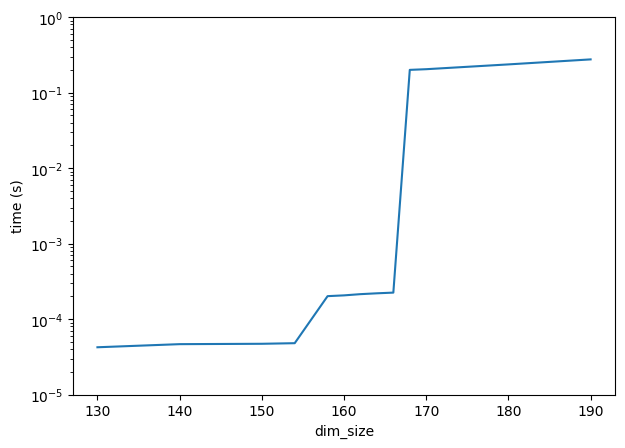

In [137]:
import matplotlib.pyplot as plt

theoretical_limit = math.floor((30720 * 1024 / 8)**(1/3))

plt.figure(figsize=(7, 5), dpi=100)
#plt.semilogy([theoretical_limit, theoretical_limit], [1e-5, 10], "k-.", alpha=0.5)
plt.semilogy(dim_sizes, times)
plt.ylim([1e-5, 1])
plt.xlabel("dim_size")
plt.ylabel("time (s)");
#plt.savefig("plots/time_vs_dim_size.png", dpi=300, bbox_inches="tight")
#plt.savefig("plots/time_vs_dim_size.eps", dpi=300, bbox_inches="tight")

We see little difference in performance until the size of the dimension is larger than 155. Later, there there is a huge increase (3 orders of magnitude!) when size of the dimension becomes larger 168. Knowing that the NumPy data buffer has size $\text{itemsize}\times \text{dim_size}^3$, we can guess that the L3 cache of the CPU where we are running this code is somewhere in between

In [138]:
L3_lower_bound = 8 * 155**3
L3_upper_bound = 8 * 168**3
print(f"Lower bound L3 cache: {L3_lower_bound / 1024:.0f} kB")
print(f"Lower bound L3 cache: {L3_upper_bound / 1024:.0f} kB")

Lower bound L3 cache: 29093 kB
Lower bound L3 cache: 37044 kB


In [139]:
!lscpu | grep L3

L3 cache:            30720K


Theoretically, we can also find a formula for the `dim_size` we expect to see a performance hit for arbitrary L3 cache sizes

$$
\text{dim_size} \leq \bigg\lfloor \sqrt[3]{\frac{\text{cache_size}}{8}}\bigg\rfloor
$$